# 02_04_Differtial_Photometry

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, astropy, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name==version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

In [53]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, photutils, ccdproc, imexam, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is not installed... now start install")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"****** module {pkg} is installed")
    else: 
        print(f"**** module {pkg} is installed")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module photutils is installed
**** module ccdproc is installed
**** module imexam is installed
**** module version_information is installed


### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [54]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-02-02 05:44:33 (KST = GMT+0900) 
0 Python     3.8.16 64bit [GCC 11.2.0]
1 IPython    8.8.0
2 OS         Linux 5.15.0 58 generic x86_64 with glibc2.17
3 numpy      1.22.3
4 pandas     1.5.2
5 matplotlib 3.6.3
6 scipy      1.8.1
7 astropy    5.2.1
8 photutils  1.6.0
9 ccdproc    2.4.0
10 imexam     0.9.1
11 version_information 1.0.4


### import modules

In [55]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clip, sigma_clipped_stats

from astropy.nddata import Cutout2D

from astropy.time import Time
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.centroids import centroid_com
from photutils import aperture_photometry as apphot

from ccdproc import CCDData, ccd_process

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
#import ysvisutilpy as yvu

import _Python_utilities
import _astro_utilities

from astropy.time import Time
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

plt.rcParams.update({'figure.max_open_warning': 0})

/tmp/ipykernel_22235/4159306980.py:23: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry as apphot


In [56]:
#%%
BASEDIR = _astro_utilities.base_dir

BASEDIRs = sorted(_Python_utilities.getFullnameListOfsubDir(BASEDIR))
print ("BASEDIRs: {}".format(BASEDIRs))
print ("len(BASEDIRs): {}".format(len(BASEDIRs)))


BASEDIR = Path(BASEDIRs[2])
print ("Starting...\n{}".format(BASEDIR))

BASEDIR = Path(BASEDIR)

BASEDIR = Path(BASEDIR)
SOLVEDDIR = BASEDIR / _astro_utilities.solved_dir2
AsteroidRESULTDIR = BASEDIR / _astro_utilities.Asteroid_result_dir

if not AsteroidRESULTDIR.exists():
    os.makedirs("{}".format(str(AsteroidRESULTDIR)))
    print("{} is created...".format(str(AsteroidRESULTDIR)))

BASEDIRs: ['/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-23_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-24_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-27_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-11-02_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-11-04_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-11-17_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/LANDOLT-114670_Light_-_2022-10-23_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/LANDOLT-114670_Light_-_2022-10-24_-

In [57]:
#%%
#####################################################################
# Our object (will be queried to JPL HORIZONS)
OBJID = '216' # Kleopatra

# Observed location
LOCATION = dict(lon = 127.0, lat = 37.3, elevation = 130)

# It is used as a rough estimate, so no need to be accurate:
PIX2ARCSEC = 1.24 * u.arcsec

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit = u.deg, frame = 'icrs')

# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5 * FWHM_INIT # Aperture radius
R_IN = 4 * FWHM_INIT   # Inner radius of annulus
R_OUT = 6 * FWHM_INIT  # Outer radius of annulus
#####################################################################

In [58]:
#summary = yfu.make_summary(BASEDIR/"*.fit*")
summary = yfu.make_summary(SOLVEDDIR/"*.fit*")

if summary.empty:
        print("The dataframe(summary) is empty")
        pass
else:
    print("len(summary):", len(summary))
    print("summary:", summary)

All 95 keywords (guessed from /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_b_2022-10-25-10-15-50_240sec_RiLA600_STX-16803_-20C_2bin.fit) will be loaded.
len(summary): 75
summary:                                                  file  filesize  SIMPLE  \
0   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
1   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
2   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
3   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
4   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
..                                                ...       ...     ...   
70  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
71  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
72  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_.

### Light

In [59]:
df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
df_light = df_light.reset_index(drop=True)
print("df_light:\n{}".format(df_light))


df_light:
                                                 file  filesize  SIMPLE  \
0   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
1   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
2   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
3   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16839360    True   
4   /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
..                                                ...       ...     ...   
70  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
71  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
72  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
73  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
74  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   

    BITPIX  NAXIS  NAXIS1  NAXIS2             FITS-TLM IMAGETYP  EXPOSURE  \
0 

In [60]:
for filt in ["r"]:
    df_light_filt = df_light.loc[df_light["FILTER"] == filt].copy()
    
    if df_light_filt.empty:
        print("The dataframe(df_light_filt) is empty")
        pass
    else:
        print("df_light_filt:", df_light_filt)
        print("len(df_light_filt):", len(df_light_filt))

df_light_filt:                                                  file  filesize  SIMPLE  \
25  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
26  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
27  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
28  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
29  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
30  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
31  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
32  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
33  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
34  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
35  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True   
36  /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_...  16842240    True  

In [61]:
for _, row  in df_light_filt.iterrows():
	fpath = Path(row["file"])
	print("type(fpath)", type(fpath))
	print("fpath", fpath)

type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-22-12_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-31-56_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-41-41_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-51-24_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpat

In [62]:
#%%
# load as ccd
ccd = yfu.load_ccd(fpath, 
					unit="adu")

## Get the Ephemeris
_, eph, _ = ypu.horizons_query(OBJID, 
						epochs=Time(ccd.header["DATE-OBS"]).jd, 
						location=LOCATION)
print("eph:", eph)
eph.write("{}_eph-{}.csv"\
			.format(str(AsteroidRESULTDIR / fpath.stem), OBJID),
			overwrite = True)

# Initial Photometry of the Target
pos_targ_init = SkyCoord(eph["RA"], 
						eph["DEC"], 
						**SKYC_KW).to_pixel(ccd.wcs)
targ_ap = CAp([pos_targ_init[0][0], 
				pos_targ_init[1][0]], 
				r=R_AP)
targ_an = CAn([pos_targ_init[0][0], 
				pos_targ_init[1][0]], 
				r_in=R_IN, 
				r_out=R_OUT)
print("pos_targ_init:", pos_targ_init)

phot_targ = ypu.apphot_annulus(ccd, 
								targ_ap, 
								targ_an, 
								error=yfu.errormap(ccd))
print("phot_targ:", phot_targ)

#%%
# 별의 목록을 가져옴.
r_fov = yfu.fov_radius(ccd.header+ccd.wcs.to_header())
print("r_fov: ", r_fov)

ps1 = ypu.PanSTARRS1(
					ccd.wcs.wcs.crval[0]*u.deg, 
					ccd.wcs.wcs.crval[1]*u.deg, 
					radius=r_fov,
					column_filters = {"{}mag".format(filt.lower()):"12.0..14.5", 
									"e_{}mag".format(filt.lower()):"<0.10", 
									"nr":">5"}
						)
print("ps1:", ps1)
#%%
# 가까이 붙어 있는 별은 지우자.
isnear = ypu.organize_ps1_and_isnear(
								ps1, 
								header = ccd.header+ccd.wcs.to_header(), 
								bezel = 5*FWHM_INIT * PIX2ARCSEC.value,
								nearby_obj_minsep= 5 * FWHM_INIT*PIX2ARCSEC.value,
								group_crit_separation = 6 * FWHM_INIT
								)
print("isnear:", isnear)

# 별의 목록
df_stars = ps1.queried.to_pandas()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
eph:        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Oct-25 14:15:35.121 ... 353.1432 9.1855
pos_targ_init: (array([770.59578398]), array([1286.49099174]))
phot_targ:    id     xcenter      ycenter  aperture_sum  aperture_sum_err          msky  \
0   1  770.595784  1286.490992  4.348160e+06       2085.224111  12032.365791   

        ssky  nsky  nrej      aparea    source_sum  source_sum_err       mag  \
0  92.436014  2234    26  254.469005  1.286295e+06     2553.908537 -9.635171   

       merr       snr  bad  nbadpix  
0  0.002156  503.6576    0        0  
r_fov:  0.35301918848947234 deg
ps1: <ysphotutilpy.queryutil.PanSTARRS1 object at 0x7f5754b47130>


/home/guitar79/Downloads/ysphotutilpy/ysphotutilpy/queryutil.py:875: UserWarning: minsep is not Quantity. Assuming degree unit.
  warn("minsep is not Quantity. Assuming degree unit.")
/home/guitar79/Downloads/ysphotutilpy/ysphotutilpy/queryutil.py:436: UserWarning: There are objects near the target!
  warn("There are objects near the target!")


 39 objects remaining:   5 masked out of  44 based on [37.2 37.2]-pixel bezel.
 39 objects remaining:   0 masked out of  39 based on DAOGROUP with 36.000-pixel critical separation..
 38 objects remaining:   1 masked out of  39 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 32 objects remaining:   6 masked out of  38 based on the Kron magnitude criterion.
 32 objects remaining:   0 masked out of  32 based on o_['g', 'r', 'i']mag >= [0 0 0].
isnear: True


In [63]:
if df_stars.empty:
		print("The dataframe(df_stars) is empty")
		pass

else:
	print(df_stars)
	print("len(df_stars):", len(df_stars))

	df_stars.to_csv("{}_stars.csv".format(str(AsteroidRESULTDIR / fpath.stem)))
	print("df_stars:", df_stars)

           _r     RAJ2000   DEJ2000               objID    f_objID  Ng  Nr  \
0    118.8036  339.805583  3.379149  112053398055805468  503635968  10  13   
1    225.6480  339.810941  3.292179  111953398109281122  503635968  12  18   
2    445.8132  339.857895  3.233438  111883398578760629  503635968  14  16   
3    505.2888  339.765833  3.480004  112173397658066520  503635968  14  16   
4    538.6140  339.975520  3.360617  112033399755003201  503635968  14  18   
5    591.9516  339.778533  3.510573  112213397784743293  503635968  11  14   
6    654.6240  339.777671  3.177702  111813397776673740  503635968  16  18   
7    697.0176  339.886327  3.537029  112243398862804937  503635968   8  14   
8    702.2628  339.988224  3.244571  111893399881773988  503635968  13  17   
9    727.4340  339.981547  3.223975  111863399815039264  503635968  18  14   
10   759.4092  340.035306  3.325307  111993400352730832  503635968  16  22   
11   761.2236  339.634685  3.444175  112133396346383481  1680916

/tmp/ipykernel_22235/3124526781.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs = plt.subplot(projection=ccd.wcs, label='overlay')


Starting photometry star 0:
phot_stars:     id     xcenter     ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  1055.78653  818.694113  3.079459e+06        1754.83874  11893.090958   

        ssky  nsky  nrej      aparea  ...       mag      merr        snr  bad  \
0  96.484464  2256     4  254.469005  ... -6.173245  0.047785  22.721506    0   

   nbadpix       Rmag    e_Rmag  grcolor  e_grcolor               objID  
0        0  13.498436  0.015003   0.3753   0.002319  112053398055805472  

[1 rows x 22 columns]
Starting photometry star 1:
phot_stars:     id      xcenter     ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  1055.786530  818.694113  3.079459e+06       1754.838740  11893.090958   
0   1  1307.734914  839.494949  3.074642e+06       1753.465671  11966.619750   

        ssky  nsky  nrej      aparea  ...       mag      merr        snr  bad  \
0  96.484464  2256     4  254.469005  ... -6.173245  0.047785  22.721506    0   
0  90.947027  2247    

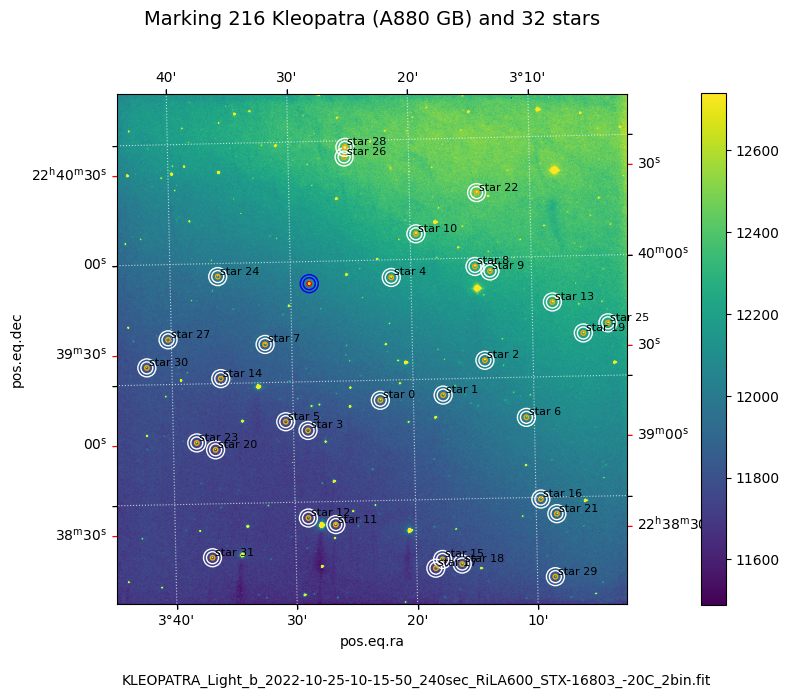

In [68]:
#%%
fig, axs = plt.subplots(1, 1, 
						figsize=(8, 8), 
						sharex=False, 
						sharey=False, 
						gridspec_kw=None
						)

axs = plt.subplot(projection=ccd.wcs, label='overlay')

im = yvu.norm_imshow(axs, 
				ccd, zscale=True)

plt.colorbar(im, 
			ax=axs,
			fraction=0.042, #0.0455
			#aspect=10,
			pad=0.12)
overlay = axs.get_coords_overlay('fk5')
                            #overlay = ax.get_coords_overlay('icrs')
overlay.grid(True, color='white', ls=':', alpha=0.7)
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

# sat tick label
lon, lat = axs.coords
lon.set_ticks(color='red')
lon.set_ticks_position('lbtr')
lon.set_ticklabel_position('lbtr')
lat.set_ticks(color='blue')
lat.set_ticks_position('lbtr')
lat.set_ticklabel_position('lbtr')

plt.title(f"Marking {eph['targetname'][0]} and {len(df_stars)} stars",
		fontsize = 14, pad=50)

plt.annotate(f"{str(fpath.name)}",
		fontsize=10, xy=(0, 0), xytext=(3, -50), va='top', ha='left',
		xycoords='axes fraction', textcoords='offset points')
#
targ_ap.plot(axs, color="r")
targ_an.plot(axs, color="b")

# 각 별의 측광을 수행
_phot_stars = []
for idx, row in df_stars.iterrows():
	print("Starting photometry star {}:".format(idx))

	#별의 적경, 적위를 이미지 안에서의 픽셀 값으로 
	pos_star = SkyCoord(row["RAJ2000"], 
						row["DEJ2000"], 
						**SKYC_KW).to_pixel(ccd.wcs)
	ap = CAp([pos_star[0], 
				pos_star[1]], 
				r=R_AP)
	an = CAn([pos_star[0], 
				pos_star[1]], 
				r_in=R_IN, 
				r_out=R_OUT)
	_phot_star = ypu.apphot_annulus(ccd, ap, an, 
					error=yfu.errormap(ccd))
	_phot_star["{}mag".format(filt.upper())] = row["{}mag".format(filt.upper())]
	_phot_star["e_{}mag".format(filt.upper())] = row["e_{}mag".format(filt.upper())]
	_phot_star["grcolor"] = row["grcolor"]
	_phot_star["e_grcolor"] = row["e_grcolor"]
	_phot_star["id"] = idx
	_phot_star["objID"] = int(row["objID"])
	_phot_stars.append(_phot_star)
	axs.text(pos_star[0]+10, 
			pos_star[1]+10, 
			f"star {idx}", 
			fontsize=8)
	ap.plot(axs, color="orange")
	an.plot(axs, color="w")
	
	plt.tight_layout()
	plt.savefig("{}_stars.png".format(str(AsteroidRESULTDIR / fpath.stem)))
	#plt.show()
	#%%
	phot_stars = pd.concat(_phot_stars)
	# phot_stars = phot_stars.loc[phot_stars["objID"] != 110823405221754720].copy()  # star 15
	# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
	print("phot_stars: ", phot_stars)
	phot_stars.to_csv("{}_phot_stars.csv".format(str(AsteroidRESULTDIR / fpath.stem)))

In [65]:
# %%
# Centroid and Re-photometry
_phot_stars = []
for idx, row in df_stars.iterrows():
    print("Starting RE-photometry star {}:".format(idx))

    #1. 별의 적경, 적위를 이미지 안에서의 픽셀 값으로 
    pos_star = SkyCoord(row["RAJ2000"], 
                        row["DEJ2000"], 
                        **SKYC_KW).to_pixel(ccd.wcs)
    
    #2. Loading and Cut Data
    cutsizes = 32
    cut_hdu = Cutout2D(
                data = ccd, 
                position = ([pos_star[0], pos_star[1]]), 
                size=(cutsizes, cutsizes) #cut ccd
                )
    avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.
    thresh_3sig = med + 3 * std
    mask_3sig = (cut_hdu.data < thresh_3sig)
    center = centroid_com(
                data = cut_hdu.data, 
                mask = mask_3sig
                )
    
    centerdx = int(cutsizes/2-center[0])
    centerdy = int(cutsizes/2-center[1])

    print("type(center):", type(center))
    print("center:", center)
    print("center dx, dy:", centerdx, centerdy)
    print("center dx, dy:", centerdx, centerdy)
    print("center dx, dy:", centerdx, centerdy)

    #3. Loading and RE-Cut Data with New center
    bigcutsizes = 100
    bigcut_hdu = Cutout2D(
                data = ccd, 
                position = ([pos_star[0], pos_star[1]]), 
                size=(bigcutsizes, bigcutsizes) #cut ccd
                )
    avg, med, std = sigma_clipped_stats(bigcut_hdu.data)  # by default, 3-sigma 5-iteration.

    #4. re center Aperture and Annulus
    bigcenter = [bigcutsizes/2 - centerdx, bigcutsizes/2 - centerdy]
    
    
    ap = CAp(positions = bigcenter, 
            r=R_AP)
    an = CAn(positions = bigcenter, 
            r_in=R_IN, 
            r_out=R_OUT)
    
    print("ap", ap)
    print("type(ap)", type(ap))
    print("an", an)
    print("type(an)", type(an))

    _phot_star = ypu.apphot_annulus(ccd, ap, an, 
                                    error=yfu.errormap(ccd))

    _phot_star["{}mag".format(filt.upper())] = row["{}mag".format(filt.upper())]
    _phot_star["e_{}mag".format(filt.upper())] = row["e_{}mag".format(filt.upper())]
    _phot_star["grcolor"] = row["grcolor"]
    _phot_star["e_grcolor"] = row["e_grcolor"]
    _phot_star["id"] = idx
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    axs.text(pos_star[0]+10, 
            pos_star[1]+10, 
            f"star {idx}", 
            fontsize=8)
    ap.plot(axs, color="orange")
    an.plot(axs, color="w")
plt.title("Marking {} and Re-centering {} stars".format(eph["targetname"][0], 
        len(df_stars)), fontsize = 14)
plt.tight_layout()
plt.savefig("{}_stars_Re.png".format(str(AsteroidRESULTDIR / fpath.stem)))
#plt.show()
#%%
phot_stars = pd.concat(_phot_stars)
# phot_stars = phot_stars.loc[phot_stars["objID"] != 110823405221754720].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
print("phot_stars: ", phot_stars)
phot_stars.to_csv("{}_phot_stars_Re.csv".format(str(AsteroidRESULTDIR / fpath.stem)))

type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-22-12_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-31-56_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-41-41_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_r_2022-10-25-10-51-24_180sec_RiLA600_STX-16803_-20C_2bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpat

In [66]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    print("type(fpath)", type(fpath))
    print("fpath", fpath)

    hdul = fits.open(fpath)

    hdr = hdul[0].header
    img = hdul[0].data
    print("img: {}".format(img))
    print("img.shape: {}".format(img.shape))

    # Set WCS and print for your information
    w = WCS(hdr)
    print("WCS: {}".format(w))

    thresh = detect_threshold(data=img, nsigma=3)
    thresh = thresh[0][0]
    print('detect_threshold', thresh)

    #%%
    try:
        
        FWHM   = 6
        
        IRAFfind = IRAFStarFinder(
                                fwhm = FWHM, 
                                threshold = thresh,
                                sigma_radius = 1.5, minsep_fwhm = 2.5,  # default values: sigma_radius=1.5, minsep_fwhm=2.5,
                                sharplo = 0.5, sharphi = 2.0,   # default values: sharplo=0.5, sharphi=2.0,
                                roundlo = 0.0, roundhi = 0.2,   # default values: roundlo=0.0, roundhi=0.2,
                                sky = None,                     # default values: sky=None
                                exclude_border = True  # default values: exclude_border=False
                                )
                            
        # The IRAFStarFinder object ("IRAFfind") gets at least one input: the image.
        # Then it returns the astropy table which contains the aperture photometry results:
        IRAFfound = IRAFfind(img)
        print('{} star(s) founded by IRAFStarFinder...'.format(len(IRAFfound)))

        #%%
        if len(IRAFfound)==0 :
            print ('No star was founded by IRAFStarFinder...\n'*3)
        else : 

            # Use the object "found" for aperture photometry:
            N_stars = len(IRAFfound)
            print('{} star(s) founded by IRAFStarFinder...'.format(N_stars))
            IRAFfound.pprint(max_width=1800)

            # save XY coordinates:
            IRAFfound.write("{}/{}_IRAFStarfinder_fwhm{}.csv".\
                            format(IRAFRESULTDIR, fpath.stem, FWHM), 
                            overwrite = True,
                            format='ascii.fast_csv')

            print('type(IRAFfound): {}'.format(type(IRAFfound)))
            print('IRAFfound: {}'.format(IRAFfound))

            IRAFcoord = np.array([IRAFfound['xcentroid'], IRAFfound['ycentroid']]).T
            print('type(IRAFcoord): {}'.format(type(IRAFcoord)))
            print('IRAFcoord: {}'.format(IRAFcoord))

            #%%
            # Save apertures as circular, 4 pixel radius, at each (X, Y)
            IRAFapert = CAp((IRAFcoord), r=4.)  
            print('type(IRAFapert): {}'.format(type(IRAFapert)))
            print('IRAFapert: {}'.format(IRAFapert))
            print('dir(IRAFapert): {}'.format(dir(IRAFapert)))

            IRAFannul = CAn(positions = (IRAFcoord), r_in = 4*FWHM, r_out = 6*FWHM) 
            print('type(IRAFannul): {}'.format(type(IRAFannul)))
            print('IRAFannul: {}'.format(IRAFannul))

            #%%
            plt.figure(figsize=(20,20))
            ax = plt.gca()

            ###########################################################
            # input some text for explaination. 
            plt.title("Result of IRAFStarfinder", fontsize = 28, 
                ha='center')

            plt.annotate('filename: {}'.format(fpath.stem), fontsize=10,
                xy=(1, 0), xytext=(-500, -40), va='top', ha='left',
                xycoords='axes fraction', textcoords='offset points')
                        
            plt.annotate('FWHM: {}'.format(FWHM), fontsize=10,
                xy=(1, 0), xytext=(-1100, -30), va='top', ha='left',
                xycoords='axes fraction', textcoords='offset points')
                
            plt.annotate('Sky threshold: {:02f}'.format(thresh), fontsize=10,
                xy=(1, 0), xytext=(-1100, -40), va='top', ha='left',
                xycoords='axes fraction', textcoords='offset points')

            plt.annotate('Number of star(s): {}'.format(len(IRAFfound)), fontsize=10,
                xy=(1, 0), xytext=(-1100, -50), va='top', ha='left',
                xycoords='axes fraction', textcoords='offset points')

            im = plt.imshow(img, 
                            vmin = thresh, 
                            vmax = thresh * 3,
                            #zscale=True,
                            origin='lower'
                            )

            IRAFannul.plot(color='red', lw=2., alpha=0.4)
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.05)
            plt.colorbar(im, cax=cax)

            plt.savefig(
                        "{}/{}_IRAFStarfinder_fwhm{}.png".\
                            format(IRAFRESULTDIR, fpath.stem, FWHM)
                        )
            print("{}/{}_IRAFStarfinder_fwhm{}.png is created...".\
                            format(IRAFRESULTDIR, fpath.stem, FWHM))
            #plt.show()
            plt.close() 

    except Exception as err:
        print('{0} with {1} '.format(err, fpath.name))

type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/RiLA600_STX-16803_2bin/KLEOPATRA_Light_-_2022-10-25_-_RiLA600_STX-16803_-_2bin/solved2/KLEOPATRA_Light_b_2022-10-25-10-15-50_240sec_RiLA600_STX-16803_-20C_2bin.fit
img: [[12100.838 11686.392 12056.411 ... 12248.48  12313.775 12423.822]
 [11756.668 11934.19  12006.21  ... 11938.663 11909.666 12017.132]
 [11840.709 12103.348 11713.838 ... 11926.96  11972.871 11854.811]
 ...
 [11806.771 11775.894 11985.235 ... 11519.986 11614.782 11425.722]
 [11705.343 11665.626 11762.753 ... 11425.027 11562.915 11695.603]
 [12011.237 11835.775 11796.726 ... 11422.842 11337.07  11569.008]]
img.shape: (2048, 2048)
WCS: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 340.05656751  3.23230062209  
CRPIX : 1505.78067017  1236.8245697  
CD1_1 CD1_2  : -5.60119779992e-06  0.000344722110361  
CD2_1 CD2_2  : -0.000344740573609  -5.76684973773e-06  
NAXIS : 2048  2048


NameError: name 'detect_threshold' is not defined